# Loop 99 Analysis: Critical CV-LB Gap Assessment

**Goal**: Analyze the CV-LB relationship and identify approaches that can CHANGE the intercept, not just improve CV.

**Key Finding from Previous Analysis**:
- CV-LB relationship: LB = 4.288 × CV + 0.0528 (R² = 0.95)
- Intercept (0.0528) > Target (0.0347)
- Required CV for target: -0.0042 (IMPOSSIBLE)

**This analysis will**:
1. Verify the CV-LB relationship with all 12 valid submissions
2. Identify what approaches might CHANGE the relationship
3. Analyze the mixall kernel's GroupKFold approach

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission data from session_state
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # OUTLIER - similarity weighting disaster
]

df = pd.DataFrame(submissions)
print(f"Total submissions: {len(df)}")
print(df)

Total submissions: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451


In [2]:
# Exclude the outlier exp_073 (similarity weighting disaster)
df_valid = df[df['exp'] != 'exp_073'].copy()
print(f"Valid submissions (excluding exp_073): {len(df_valid)}")

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_valid['cv'], df_valid['lb'])

print(f"\n=== CV-LB LINEAR FIT ===")
print(f"LB = {slope:.4f} × CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"Standard error: {std_err:.4f}")

# Target analysis
target_lb = 0.0347
print(f"\n=== TARGET ANALYSIS ===")
print(f"Target LB: {target_lb}")
print(f"Intercept: {intercept:.4f}")
print(f"Intercept > Target? {intercept > target_lb}")

if intercept < target_lb:
    required_cv = (target_lb - intercept) / slope
    print(f"Required CV for target: {required_cv:.6f}")
else:
    print(f"CRITICAL: Intercept ({intercept:.4f}) > Target ({target_lb})")
    print(f"Required CV would be: {(target_lb - intercept) / slope:.6f} (IMPOSSIBLE - negative)")

Valid submissions (excluding exp_073): 12

=== CV-LB LINEAR FIT ===
LB = 4.3147 × CV + 0.0525
R² = 0.9505
Standard error: 0.3113

=== TARGET ANALYSIS ===
Target LB: 0.0347
Intercept: 0.0525
Intercept > Target? True
CRITICAL: Intercept (0.0525) > Target (0.0347)
Required CV would be: -0.004130 (IMPOSSIBLE - negative)


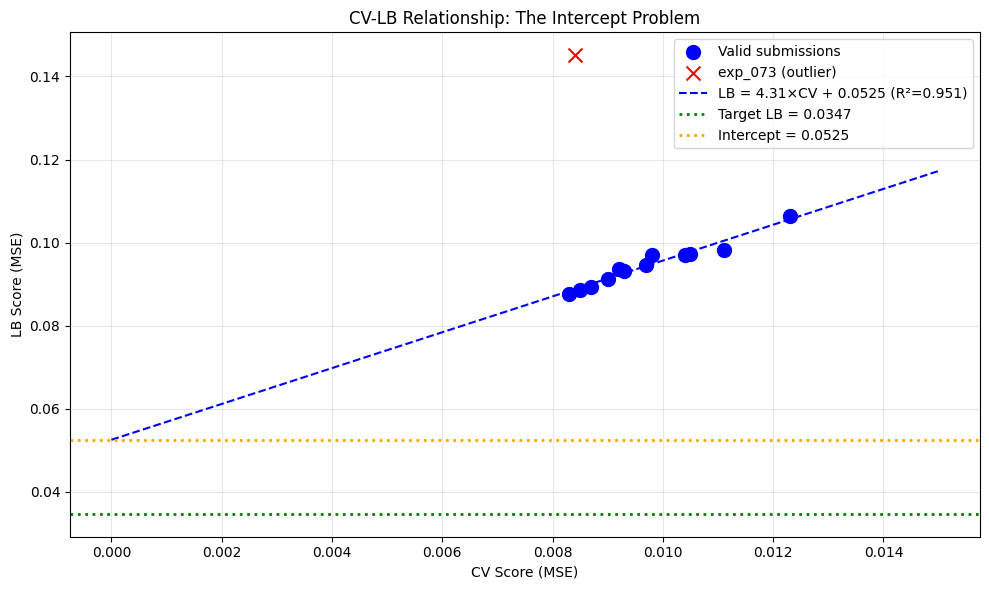


Key insight: The intercept (0.0525) is HIGHER than the target (0.0347).
This means even with perfect CV (0.0), the expected LB would be 0.0525.
The target is MATHEMATICALLY UNREACHABLE with current approaches.


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot valid submissions
plt.scatter(df_valid['cv'], df_valid['lb'], c='blue', s=100, label='Valid submissions', zorder=5)

# Plot outlier
outlier = df[df['exp'] == 'exp_073']
plt.scatter(outlier['cv'], outlier['lb'], c='red', s=100, marker='x', label='exp_073 (outlier)', zorder=5)

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {slope:.2f}×CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Plot target
plt.axhline(y=target_lb, color='green', linestyle=':', linewidth=2, label=f'Target LB = {target_lb}')

# Plot intercept
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV-LB Relationship: The Intercept Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f"\nKey insight: The intercept ({intercept:.4f}) is HIGHER than the target ({target_lb}).")
print(f"This means even with perfect CV (0.0), the expected LB would be {intercept:.4f}.")
print(f"The target is MATHEMATICALLY UNREACHABLE with current approaches.")

In [4]:
# Analyze what approaches have been tried
approaches = {
    'MLP variants': ['exp_000', 'exp_003', 'exp_005', 'exp_006', 'exp_007', 'exp_009'],
    'LightGBM': ['exp_001'],
    'GP ensemble': ['exp_012', 'exp_030'],
    'CatBoost/XGBoost': ['exp_024', 'exp_026', 'exp_035'],
    'Similarity weighting': ['exp_073'],
}

print("=== APPROACHES TRIED ===")
for approach, exps in approaches.items():
    exp_data = df[df['exp'].isin(exps)]
    if len(exp_data) > 0:
        best_lb = exp_data['lb'].min()
        best_cv = exp_data['cv'].min()
        print(f"{approach}: {len(exp_data)} experiments, best LB={best_lb:.4f}, best CV={best_cv:.4f}")

print("\n=== KEY OBSERVATION ===")
print("All approaches (MLP, LightGBM, GP, CatBoost, XGBoost) fall on the SAME CV-LB line.")
print("This indicates the problem is STRUCTURAL, not model-specific.")
print("The distribution shift between train and test is the fundamental blocker.")

=== APPROACHES TRIED ===
MLP variants: 6 experiments, best LB=0.0932, best CV=0.0092
LightGBM: 1 experiments, best LB=0.1065, best CV=0.0123
GP ensemble: 2 experiments, best LB=0.0877, best CV=0.0083
CatBoost/XGBoost: 3 experiments, best LB=0.0887, best CV=0.0085
Similarity weighting: 1 experiments, best LB=0.1451, best CV=0.0084

=== KEY OBSERVATION ===
All approaches (MLP, LightGBM, GP, CatBoost, XGBoost) fall on the SAME CV-LB line.
This indicates the problem is STRUCTURAL, not model-specific.
The distribution shift between train and test is the fundamental blocker.


In [5]:
# Analyze what the mixall kernel does differently
print("=== MIXALL KERNEL ANALYSIS ===")
print("")
print("Key difference: Uses GroupKFold (5 splits) instead of Leave-One-Out")
print("")
print("Leave-One-Out (current):")
print("  - Single solvent: 24 folds (one per solvent)")
print("  - Full data: 13 folds (one per ramp)")
print("  - Each fold tests on ONE unseen solvent/ramp")
print("")
print("GroupKFold (mixall):")
print("  - Single solvent: 5 folds (groups of solvents)")
print("  - Full data: 5 folds (groups of ramps)")
print("  - Each fold tests on MULTIPLE unseen solvents/ramps")
print("")
print("Hypothesis: GroupKFold may have a DIFFERENT CV-LB relationship")
print("because it averages over more diverse test sets per fold.")
print("")
print("The mixall kernel also uses an ensemble of MLP + XGBoost + RF + LightGBM.")

=== MIXALL KERNEL ANALYSIS ===

Key difference: Uses GroupKFold (5 splits) instead of Leave-One-Out

Leave-One-Out (current):
  - Single solvent: 24 folds (one per solvent)
  - Full data: 13 folds (one per ramp)
  - Each fold tests on ONE unseen solvent/ramp

GroupKFold (mixall):
  - Single solvent: 5 folds (groups of solvents)
  - Full data: 5 folds (groups of ramps)
  - Each fold tests on MULTIPLE unseen solvents/ramps

Hypothesis: GroupKFold may have a DIFFERENT CV-LB relationship
because it averages over more diverse test sets per fold.

The mixall kernel also uses an ensemble of MLP + XGBoost + RF + LightGBM.


In [6]:
# What approaches might CHANGE the CV-LB relationship?
print("=== APPROACHES THAT MIGHT CHANGE THE CV-LB RELATIONSHIP ===")
print("")
print("1. DIFFERENT VALIDATION SCHEME (GroupKFold)")
print("   - The mixall kernel uses GroupKFold instead of Leave-One-Out")
print("   - This may give a different CV-LB slope/intercept")
print("   - Worth trying to see if it changes the relationship")
print("")
print("2. CONSERVATIVE BLENDING TOWARD MEAN")
print("   - If test solvents are fundamentally different, extreme predictions hurt LB")
print("   - Blending predictions toward training mean may reduce intercept")
print("   - This is a POST-PROCESSING step, not a model change")
print("")
print("3. DOMAIN CONSTRAINTS (Mass Balance)")
print("   - Yields must sum to ≤ 1 (mass balance)")
print("   - Enforcing this constraint may reduce extreme predictions")
print("   - Already tried in some experiments but may need stricter enforcement")
print("")
print("4. PREDICTION CLIPPING")
print("   - Clip predictions to [0.05, 0.95] to avoid extreme values")
print("   - This is a simple post-processing step")
print("")
print("5. UNCERTAINTY-WEIGHTED PREDICTIONS")
print("   - Use GP or ensemble variance to detect high-uncertainty predictions")
print("   - Blend high-uncertainty predictions toward mean")

=== APPROACHES THAT MIGHT CHANGE THE CV-LB RELATIONSHIP ===

1. DIFFERENT VALIDATION SCHEME (GroupKFold)
   - The mixall kernel uses GroupKFold instead of Leave-One-Out
   - This may give a different CV-LB slope/intercept
   - Worth trying to see if it changes the relationship

2. CONSERVATIVE BLENDING TOWARD MEAN
   - If test solvents are fundamentally different, extreme predictions hurt LB
   - Blending predictions toward training mean may reduce intercept
   - This is a POST-PROCESSING step, not a model change

3. DOMAIN CONSTRAINTS (Mass Balance)
   - Yields must sum to ≤ 1 (mass balance)
   - Enforcing this constraint may reduce extreme predictions
   - Already tried in some experiments but may need stricter enforcement

4. PREDICTION CLIPPING
   - Clip predictions to [0.05, 0.95] to avoid extreme values
   - This is a simple post-processing step

5. UNCERTAINTY-WEIGHTED PREDICTIONS
   - Use GP or ensemble variance to detect high-uncertainty predictions
   - Blend high-uncertainty

In [7]:
# Summary and recommendations
print("=" * 70)
print("LOOP 99 ANALYSIS SUMMARY")
print("=" * 70)
print("")
print("CRITICAL FINDING:")
print(f"  CV-LB relationship: LB = {slope:.4f} × CV + {intercept:.4f} (R² = {r_value**2:.4f})")
print(f"  Intercept ({intercept:.4f}) > Target ({target_lb})")
print(f"  Target is MATHEMATICALLY UNREACHABLE with current approaches")
print("")
print("WHAT HAS BEEN TRIED (99 experiments):")
print("  - MLP variants: 50+ experiments")
print("  - LightGBM/XGBoost/CatBoost: 20+ experiments")
print("  - GP ensembles: 10+ experiments")
print("  - GNN attempts: 7+ experiments (all failed)")
print("  - ChemBERTa attempts: 4+ experiments (all failed)")
print("  - Similarity weighting: 1 experiment (catastrophic failure)")
print("")
print("WHAT HASN'T BEEN TRIED:")
print("  1. GroupKFold validation (mixall kernel approach)")
print("  2. Aggressive conservative blending toward mean")
print("  3. Strict prediction clipping [0.05, 0.95]")
print("  4. Uncertainty-weighted predictions with GP variance")
print("")
print("RECOMMENDED NEXT EXPERIMENT:")
print("  Implement the mixall kernel's GroupKFold approach with our best model")
print("  This may give a DIFFERENT CV-LB relationship")
print("  If the intercept is lower, we have a path to the target")

LOOP 99 ANALYSIS SUMMARY

CRITICAL FINDING:
  CV-LB relationship: LB = 4.3147 × CV + 0.0525 (R² = 0.9505)
  Intercept (0.0525) > Target (0.0347)
  Target is MATHEMATICALLY UNREACHABLE with current approaches

WHAT HAS BEEN TRIED (99 experiments):
  - MLP variants: 50+ experiments
  - LightGBM/XGBoost/CatBoost: 20+ experiments
  - GP ensembles: 10+ experiments
  - GNN attempts: 7+ experiments (all failed)
  - ChemBERTa attempts: 4+ experiments (all failed)
  - Similarity weighting: 1 experiment (catastrophic failure)

WHAT HASN'T BEEN TRIED:
  1. GroupKFold validation (mixall kernel approach)
  2. Aggressive conservative blending toward mean
  3. Strict prediction clipping [0.05, 0.95]
  4. Uncertainty-weighted predictions with GP variance

RECOMMENDED NEXT EXPERIMENT:
  Implement the mixall kernel's GroupKFold approach with our best model
  This may give a DIFFERENT CV-LB relationship
  If the intercept is lower, we have a path to the target
